In [2]:
%matplotlib inline
%config InlineBackend.figure_format='svg'

In [3]:
from IPython.display import display, Math, Latex

In [4]:
import matplotlib
import matplotlib.path as mpath
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import math
import random

# Digital Image Correlation Research Project

#### Calhoun, C. & M. Forbes – George Mason University

This is the notebook containing the code for the Digital Image Correlation (DIC) research project. The goal of this project is to create a notebook that can be used to increase the accuracy and precision of DIC over current methods.

To do this there both a basic finite element model (FEM) needs to be generated. This is generated in the Python language as a basic orthonomal mesh across a rectangluar domain. More features may be added later. The mesh is then displayed.

### Introduction

Digital image correlation (DIC) is an algorithm which uses image matching to measure the deformation of a body in a configuration space, $\beta_{\kappa}$. This data is then converted into a strain field, $\epsilon$ and, when combined with known loadings, a stress-strain curve may be generated. 

A similar application, and whose method is examined within this notebook, is the role DIC performs in confirming finite element analysis (FEA) simulations. To achieve a unique solution of the DIC nodal equations at each point, the body must be covered with a speckle pattern and as the displacement of points within the pattern changes, a deformation may be computed at the specified nodes. The deformation between the nodes is then interpolated using an interpolation method. To fully capture strain in three-dimensions, a system of parallax cameras are used. Thus, deformation of the body in the incident direction may be measured.

This data may then be compared with FEA solutions, and the accuracy of the simulated results may be measured directly. 

#### Bias in DIC Models

There are two chief sources of bias in DIC models: noise bias, and interpolation bias. Noise bias is due to the multi-camera problem, and is inherant in the current system of measurement. Interpolation bias is an artifact of interpolating between the nodes.

Interpolation is done through, primarily, a bilinear shape-function method. This shape-function is commonly a complete polynomial of degree n, $p^n$, similar to the FEA model's shape-function. For maximum precision, the inital locations of the DIC nodes, $(X)_{DIC}$ are co-located as closely as possible onto the inital locations of the FEA mesh, $(X)_{FEA}$. Once the body has stopped straining, the final location of each models are recorded, $\chi_{\kappa}(X)$, and the deformation vector in the given configuration at each node is calculated through,

$u(X) = u_ie_i+u_je_j = \chi_{\kappa}(X)-X$

After the nodal values have been measured, the strain at the nodes is then computed from the deformation using,

$\epsilon_{ij} = \frac{1}{2}\big(\frac{\partial u_i}{\partial x_j}+\frac{\partial u_j}{\partial x_j} \big)$

While these values are exact, the strain between the nodes must be interpolated through an interpolation method. The two methods examined in this notebook are:
* Bilinear, and
* Moving Least Squares

Other methods are possible, given different shape functions, $\phi_i$, however, this notebook restricts itself to these two methods to highlight the difference in accuracy between a mesh-based method of interpolation (e.g., the bilinear shape function) in DIC and a mesh-less method (e.g., the moving least squares method).

#### Bilinear Interpolation Function

The bilinear interpolation method used here is used to interpolate points on a square mesh, so as to find a smooth contour graph for plotting. An element of the rectangular mesh is shown below with a local coordinate system, with nodes marked $Q_{ij}$.

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://upload.wikimedia.org/wikipedia/commons/e/ea/BilinearInterpolation.svg")

To find the value of $Q(x,y)$ at point $P$, it is necessary to interpolate within the element in both $x$ and $y$. To do so, the bilinear shape function is called, which is given by

$Q(x,y) = \frac{(x_2-x)(y_2-y)}{(x_2-x_1)(y_2-y_1)}Q_{11} + \frac{(x-x_1)(y_2-y)}{(x_2-x_1)(y_2-y_1)}Q_{21} + \frac{(x_2-x)(y-y_1)}{(x_2-x_1)(y_2-y_1)}Q_{12} + \frac{(x-x_1)(y-y_1)}{(x_2-x_1)(y_2-y_1)}Q_{22}$

This gives the value at each $x$ and $y$ within the element.

#### Moving Least Squares (MLS) Interpolation Function

### Finite Element Analysis (FEA) Model

It is assumed, for the purposes of this notebook, that the FEA model is absolutely accurate. Thus, any comparisons against the FEA model by the DIC model will result in a comparison between a known and a simulation. This allows for the FEA model to be compared with the DIC model directly. In later notebooks, this assumption will be discussed and possibly removed, in favour of a more rigorous method of analysis. For now, as the focus of the notebook is the comparison of the accuracy in DIC of a mesh-based and mesh-less method, the assumption is warranted.

Since there is an assumption of no bias within the FEA model, and the data being compared with the DIC model is only strain, no force vector need be establshed. This results in node-translation intead of requiring a force-vector, $\{f_{i}\}$, and stiffness matrix, $[K_{ij}]$, model. However, the model is still based upon a rectangluar mesh made of elements, and the approximate values are interpolated between nodes of the mesh.

#### Defining the Domain

A rectangular domain is specified for the body,

$\{(x,y) \;|\; x = [0,1000],\, y = [0,100] \} \in \beta_{\kappa}$

In terms of the python implementation of this domain, the body's local coordinate system, whose Euclidean origin is located at the bottom and left corner of the body, is located at the origin of the global coordinate system. This provides the global configuration $\kappa$, and all values of deformation are measured from this configured global configuration. The bases of this configuration space are given in a standard orthonormal basis,

$\begin{bmatrix}e_1 & e_2\end{bmatrix} = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix} \; \in \; \big(\beta_{\kappa} \subset E^2\big)$

Each axis is a number line, which is set up in the two-dimensional real number space,

$\big((x,y) \in \Re^2\big) \mapsto \beta_{\kappa} $

Since $\beta_{\kappa}$ is a finite space, the mapping of the axes is finite, so as to specify its uniqueness and existance at all points within the set. To implement the model in Python, a resolution of the points within the body is added, thus creating a finite whitespace.

In [36]:
#Parameters of whitespace
x_max = 1000.0 #maximum size of body in the x dimension
y_max = 100.0 #maximum size of body in the y dimension

x_num = 5 #number of points in the x dimension
y_num = 5 #number of points in the y dimension

#Creation of the axes
x_ax = np.linspace(0.0, x_max, x_num) #x axis real number line
y_ax = np.linspace(0.0, y_max, y_num) #y axis real number line

#### Selecting and Creating Nodes Within $\beta_{\kappa}$

Within the configured body space, $\beta_{\kappa}$, a selection of points – the nodes in the FEA mesh – are selected. These are arranged in a rectangular grid, seperated throughout the body. 

$(x_N, y_N) \subset \beta_{\kappa}$

Within the python implemention of the FEA algorithm, $x_N$ and $y_N$ coorespond to the coordinates of the points within the array of points, 'nodes_FEA'.

In [37]:
#Creation of nodes of the FEA mesh
N = x_num*y_num #total number of nodes within the mesh
x_n = x_ax[:] #the x coordinates of the nodes
y_n = y_ax[:] #the y coordinates of the nodes
print(x_n)
print(y_n)
nodes_FEA = np.zeros((N,2)) #declaring the node array

counter = [0, 0]
x_index = 0
y_index = 0
for index in range(np.shape(nodes_FEA)[0]):
    if counter[0] == 0 and x_index < x_num:
        nodes_FEA[index][0] = x_n[x_index]
        x_index += 1 
        counter[0] = 0
    if counter[1] == 0 and y_index < y_num:
        nodes_FEA[index][1] = y_n[y_index]
        y_index += 1
        counter[1] = 1
    if counter == [1, 1]:
        counter = [0, 0]
    if x_index >= x_num:
        x_index = 0
        counter[0] = 1
    if y_index >= y_num:
        y_index = 0
        counter[1] = 0
print(nodes_FEA)

#xstep = x_max/(x_num)
#ystep = y_max/(y_num)

#xcounter = 0
#ycounter = 0
#for index in range(np.shape(points)[0]):
    #if index > 0:
#        points[index][0] = points[xcounter][0] + xstep
#       points[index][1] = points[index-1][1] + ystep*ycounter
#      xcounter += 1
#        ycounter = 0
#    if index%x_num is 0:
#        xcounter = 0
#        if index is not 0:
#            ycounter = 1
#points = points[1:]

[    0.   250.   500.   750.  1000.]
[   0.   25.   50.   75.  100.]
[[    0.     0.]
 [  250.     0.]
 [  500.     0.]
 [  750.     0.]
 [ 1000.     0.]
 [    0.     0.]
 [    0.    25.]
 [  250.     0.]
 [  500.     0.]
 [  750.     0.]
 [ 1000.     0.]
 [    0.     0.]
 [    0.    50.]
 [  250.     0.]
 [  500.     0.]
 [  750.     0.]
 [ 1000.     0.]
 [    0.     0.]
 [    0.    75.]
 [  250.     0.]
 [  500.     0.]
 [  750.     0.]
 [ 1000.     0.]
 [    0.     0.]
 [    0.   100.]]


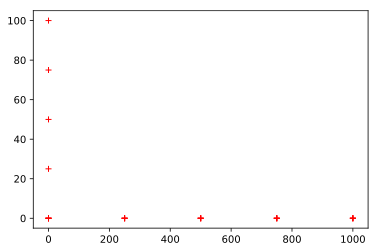

In [38]:
#Displaying undeformed points on body
plt.figure(1)
for node in nodes_FEA:
    plt.plot(node[0],node[1], 'r+')

Now that there are nodes on the whitespace for the FEA mesh, a balance matrix is necessary to interpolate them.

In [ ]:
#Building a balance matrix
balance = 0

for index, point in enumerate(points):
    

#### Creation of Deformation field and Noise

A deformation field u(x,y) is generated, and this deformation field has some random noise.

In [78]:
#Declaration of displacement field, inner products, and translation vectors
u = np.zeros((np.shape(points)[0],2))

for index in range(np.shape(u)[0]):
    #u[index][0] = 100*math.sin(1/10*math.pi*points[index][0]**2)*math.cos(random.random()) + 100
    u[index][0] = 100*math.sin(1/10*math.pi*points[index][0]**2)+ np.random.normal()
for jndex in range(np.shape(u)[0]):
    #u[jndex][1] = 10*math.cos(random.random()) -10
    u[jndex][1] = np.random.normal()

In [79]:
print(u)

[[  9.73574017e+01  -1.45753848e-01]
 [ -9.09874894e+01  -1.90847472e+00]
 [ -8.47399647e+01  -7.71707594e-01]
 ..., 
 [ -8.84206424e+01   1.67374328e-02]
 [ -7.50577103e+01   2.53434789e-01]
 [  1.24021263e+00  -1.62352609e-01]]


#### Transformation of the Inital Specimen by Deformation Field

The inital specimen is transformed by the deformation field, resulting in a new pointcloud. This pointcloud has some random noise.

In [80]:
#Transformation of points from deformation
defpoints = points[:] + u

print(defpoints)

[[  1.11643116e+02  -1.45753848e-01]
 [ -6.24160608e+01  -1.90847472e+00]
 [ -4.18828219e+01  -7.71707594e-01]
 ..., 
 [  8.83007929e+02   9.50167374e+01]
 [  9.10656575e+02   9.52534348e+01]
 [  1.00124021e+03   9.48376474e+01]]


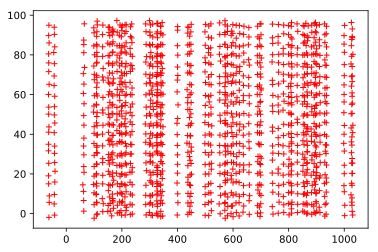

In [81]:
plt.figure(2)
for point in defpoints:
    plt.plot(point[0],point[1], 'r+')

So, there is a deformation of increasing frequency in the x-direction with noise added. This is the initial pointcloud used to compare to the digital image correlation model to be developed in the next section.

#### Interpolating Displacement Field Across Body

After the deformation at the nodes is given, the deformation at each nodes is interpolated to create a smooth deformation field between the nodes on the body.

In [16]:
#Bilinear interpolation function
def bilinear(x, y, x1, x2, y1, y2, u1, u2, u3, u4):
        phi_1 = (x - x1)/(x2 - x1)
        phi_2 = (y - y1)/(y2 - y1)
        
        u = (1-phi_1)*(1-phi_2)*u1 + phi_1*(1-phi_2)*u2 + phi_1*phi_2*u3 + (1-phi_1)*phi_2*u4
        
        return u

In [82]:
print(points[0][1])

0.0


To interpolate the deformation field across the body, the norm of the deformation field is necessary.

In [18]:
norm_u = np.zeros((np.shape(u)[0],1))
for lndex in range(np.shape(u)[0]):
    norm_u[lndex] = math.sqrt((u[lndex][0])**2+(u[lndex][1])**2)
print(norm_u)

[[ 170.3156543 ]
 [  14.850986  ]
 [  18.53365974]
 ..., 
 [  12.2057996 ]
 [  28.24135209]
 [ 100.0004982 ]]


In [19]:
#Interpolation of elements
x = np.linspace(0,xdim,num=1000)
y = np.linspace(0,ydim,num=1000)
print(np.shape(points)[0])
deflect = np.zeros((1000))
for i in range(0,1000):
        for j in range(0, np.shape(points)[0]):
            if j < (np.shape(points)[0]-nx-1):
                #deflect[i] = bilinear(x[i], y[i], points[j][0], points[j+1][0], points[j][1], points[j+1][1], norm_u[j], norm_u[j+1], norm_u[j+nx], norm_u[j+nx+1])
            #else:
            #    deflect[i] = bilinear(x[i], y[i], points[j][0], points[j+1][0], points[j][1], points[j+1][1], norm_u[j], norm_u[j+1], norm_u[j+nx], norm_u[j+nx+1]) 

SyntaxError: unexpected EOF while parsing (<ipython-input-19-8087211a05a9>, line 11)

In [20]:
#print(deflect)

The field is now displayed as a filled countour graph across the body.

In [21]:
#Visulaization of the displacement as a filled countour graph

### Digital Image Correlation (DIC) Model 

Now that a deformed body exists with a known displacement field, it is time to create the DIC nodes that will be used to measure the deformation. First the nodes locations are created, then they are plotted on the deformed body, co-located on the same coordinate plane as the mesh points.

In [22]:
#Creation of DIC node locations
nodesx = 10
nodesy = 10
DICN = nodesx*nodesy
nodes = np.zeros((DICN+1,2))

DICxstep = (xdim+100)/(nodesx)
DICystep = ydim/(nodesy)

xcounter = 0
ycounter = 0
for index in range(np.shape(nodes)[0]):
    if index > 0:
        nodes[index][0] = nodes[xcounter][0] + DICxstep
        nodes[index][1] = nodes[index-1][1] + DICystep*ycounter
        xcounter += 1
        ycounter = 0
    if index%nodesx is 0:
        xcounter = 0
        if index is not 0:
            ycounter = 1
nodes = nodes[1:]

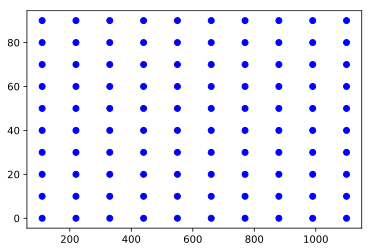

In [23]:
#Displaying DIC nodes on body
plt.figure(3)
for node in nodes:
    plt.plot(node[0],node[1], 'bo')

In [19]:
#Calculation of the deformed locations in DIC mesh from known deformation field.

In [20]:
#Calculuation of the new displacements at each node in DIC mesh.

In [21]:
#Interpolation of the displacements at each node to determine a smooth field for the DIC mesh.

In [22]:
#Visualization of the DIC displacement field as a filled countour plot over the body.

#### Interpolate Results using the Moving-Least Squares Method

Now that the DIC modes have been plotted, a method of approximating the deformation function is necessary. In the project, the interpolation method used is the Moving-Least Squares method (or MLS). 

In [28]:
#Create MLS package in python
h = 0.51

In [29]:
#Define weighting function
def weight(q, h):
    if q <= 1:
        w = 2/(3*h)*(1-3/2*q**2+3/4*q**3)
    elif q >= 1 and q <= 2:
        w = 2/(3*h)*(1/4*(2-q)**3)
    else:
        w = 0
    return w

In [41]:
#Creation of polynomial matrix, P
P = np.zeros((np.shape(points)[0],6))
for n, point in enumerate(points):
    P[n][0] = 1
    P[n][1] = point[0]
    P[n][2] = point[1]
    P[n][3] = point[0]*point[0]
    P[n][4] = point[0]*point[1]
    P[n][5] = point[1]*point[1]
print(P)

[[  1.00000000e+00   1.42857143e+01   0.00000000e+00   2.04081633e+02
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   2.85714286e+01   0.00000000e+00   8.16326531e+02
    0.00000000e+00   0.00000000e+00]
 [  1.00000000e+00   4.28571429e+01   0.00000000e+00   1.83673469e+03
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  1.00000000e+00   9.71428571e+02   9.50000000e+01   9.43673469e+05
    9.22857143e+04   9.02500000e+03]
 [  1.00000000e+00   9.85714286e+02   9.50000000e+01   9.71632653e+05
    9.36428571e+04   9.02500000e+03]
 [  1.00000000e+00   1.00000000e+03   9.50000000e+01   1.00000000e+06
    9.50000000e+04   9.02500000e+03]]


In [35]:
#Creation of weight function matix, W
W = np.eye(np.shape(points)[0], np.shape(points)[0])

x = np.linspace(0, xdim, 100)
y = np.linspace(0, ydim, 100)

for j in range(np.shape(x)[0]):
    for i in range(np.shape(points)[0]):
        q = math.sqrt((x[j]-defpoints[i][0])**2 + (y[j]-defpoints[i][1])**2)
        W[i][i] = weight(q, h)
        
print(W)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [37]:
#Solve for coefficients, a(x)
A = np.dot(np.transpose(P), np.dot(W, P))
B = np.dot(np.transpose(P), W)
a = np.dot(np.linalg.inv(A), np.dot(B, defpoints))
print(A)

LinAlgError: Singular matrix

In [ ]:
#Solve for deformation, u_p
p = np.zeros(())
u_p = np.dot()